# IHLT Lab 7

Lab developed by:
- Oriol Miró López-Feliu
- Niklas Long Schiefelbein


**Exercice description:**
1. Read all pairs of sentences of the SMT europarl files of test set within the evaluation framework of the project.
2. Compute their similarities by considering the following approach: words plus NEs and Jaccard coefficient
  - ex: word_and_NEs=`['John Smith', 'is', 'working']`
3. Show the results.
4. Do you think it could be relevant to use NEs to compute the similarity between two sentences? Justify the answer.

## Imports

In [ ]:
# Data manipulation and analysis
import pandas as pd
import numpy as np

# nltk
import nltk
from nltk.tokenize import word_tokenize
from nltk import pos_tag,  ne_chunk
from nltk.metrics import jaccard_distance
from nltk.stem import WordNetLemmatizer
from nltk.tree import Tree
from string import punctuation

nltk.download('stopwords')
nltk.download('words')
nltk.download('wordnet')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('maxent_ne_chunker_tab')
nltk.download('words')

# spacy
import spacy
nlp = spacy.load('en_core_web_sm')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Google Colab specific
from IPython import get_ipython
from IPython.display import display
from google.colab import drive
drive.mount('/content/drive')


# preprocessing
stop_words = set(nltk.corpus.stopwords.words('english'))
wnl = nltk.stem.WordNetLemmatizer()

# Distance
from nltk.metrics import jaccard_distance
from scipy.stats import pearsonr


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker_tab to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package maxent_ne_chunker_tab is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Useful functions



In [ ]:
# preprocessing
def lemmatize(p):
  d = {'NN': 'n', 'NNS': 'n',
       'JJ': 'a', 'JJR': 'a', 'JJS': 'a',
       'VB': 'v', 'VBD': 'v', 'VBG': 'v', 'VBN': 'v', 'VBP': 'v', 'VBZ': 'v',
       'RB': 'r', 'RBR': 'r', 'RBS': 'r'}
  if p[1] in d:
    return wnl.lemmatize(p[0], pos=d[p[1]])
  return p[0]


def lemmatize_sentence(tokens):
    pos_tags = nltk.pos_tag(tokens)
    lemmatized_tokens = [lemmatize(pair) for pair in pos_tags]
    return lemmatized_tokens

def compute_pearson_correlation(dt, column_name):
    return pearsonr(dt['gs'], dt[column_name])[0]

def plot_pearson_comparison(correlations, labels):

    # color palette (so we dont have to provide it, as variable nº of inputs)
    colors = sns.color_palette(n_colors=len(labels))

    # plot bar graph
    plt.figure(figsize=(8, 6))
    bars = plt.bar(labels, correlations, color=colors)

    plt.ylabel("Pearson's Correlation")
    plt.title("Comparison of Pearson's Correlation for Different Methods")
    plt.ylim(0, 1)  # Adjust the range based on your data

    # number above each bar (clarity)
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 3), ha='center', va='bottom')

    # show plot
    plt.show()

## Data Loading & Preprocessing
Also accounts for Exercise 1

In [ ]:
# load base data
dt = pd.read_csv('/content/drive/MyDrive/MAI_IHLT_LAB/data/test-gold/STS.input.SMTeuroparl.txt',sep='\t',header=None)

# include the gs labels
dt['gs'] = pd.read_csv('/content/drive/MyDrive/MAI_IHLT_LAB/data/test-gold/STS.gs.SMTeuroparl.txt',sep='\t',header=None)

In [ ]:
# preprocessing
dt.drop_duplicates(inplace=True) # as we found out before, there are 142 duplicates!

# rename columns
dt.rename(columns={0:'s0', 1:'s1'}, inplace=True)

In [ ]:
# tokenize the sentences
dt['s0_tokens'] = dt.apply(lambda row: word_tokenize(row["s0"]), axis=1)
dt['s1_tokens'] = dt.apply(lambda row: word_tokenize(row["s1"]), axis=1)

## For benchmarking, result from lab3

In [ ]:
dt['s0_preprocessed'] = dt['s0_tokens'].apply(
    lambda tokens: [
        (word, word.lower() if word.lower() not in stop_words and word not in punctuation else None)
        for word in lemmatize_sentence(tokens)
    ]
)

dt['s1_preprocessed'] = dt['s1_tokens'].apply(
    lambda tokens: [
        (word, word.lower() if word.lower() not in stop_words and word not in punctuation else None)
        for word in lemmatize_sentence(tokens)
    ]
)

dt['jd_lab3'] = dt.apply(
    lambda row: (1 - jaccard_distance(
        set([word[1] for word in row['s0_preprocessed'] if word[1] is not None]),  # use only the second element if not None
        set([word[1] for word in row['s1_preprocessed'] if word[1] is not None])
    )) * 5, axis=1
)

pearson_cor_lab3 = compute_pearson_correlation(dt, 'jd_lab3')

## Exercices

### Exercice 2
Compute their similarities by considering the following approach: words plus NEs and Jaccard coefficient ex: word_and_NEs=['John Smith', 'is', 'working']

In [ ]:
def extract_words_and_nes_nltk(sentence):
    tokens = word_tokenize(sentence)
    pos_tags = pos_tag(tokens)
    chunks = ne_chunk(pos_tags)

    words_and_nes = []
    for chunk in chunks:

        # if a named entity
        if isinstance(chunk, Tree):
            words_and_nes.append(" ".join(c[0] for c in chunk))

        # if not a named entity
        else:
            words_and_nes.append(chunk[0])

    return words_and_nes

def extract_words_and_nes_spacy(sentence):
    doc = nlp(sentence)
    with doc.retokenize() as retokenizer:
        for ent in doc.ents:
            retokenizer.merge(doc[ent.start:ent.end],
                              attrs={"LEMMA": " ".join([token.text for token in ent])})
    return [token.text for token in doc]

In [ ]:
dt['s0_nltk'] = dt['s0'].apply(extract_words_and_nes_nltk)
dt['s1_nltk'] = dt['s1'].apply(extract_words_and_nes_nltk)

dt['s0_spacy'] = dt['s0'].apply(extract_words_and_nes_spacy)
dt['s1_spacy'] = dt['s1'].apply(extract_words_and_nes_spacy)

In [ ]:
dt['jd_nltk'] = dt.apply(
    lambda row: (1 - jaccard_distance(
        set([word.lower() for word in row['s0_nltk'] if word.lower() not in stop_words and word not in punctuation]),
        set([word.lower() for word in row['s1_nltk'] if word.lower() not in stop_words and word not in punctuation])
    )) * 5, axis=1
)

dt['jd_spacy'] = dt.apply(
    lambda row: (1 - jaccard_distance(
        set([word.lower() for word in row['s0_spacy'] if word.lower() not in stop_words and word not in punctuation]),
        set([word.lower() for word in row['s1_spacy'] if word.lower() not in stop_words and word not in punctuation])
    )) * 5, axis=1
)

In [ ]:
pearson_cor_nltk = compute_pearson_correlation(dt, 'jd_nltk')
pearson_cor_spacy = compute_pearson_correlation(dt, 'jd_spacy')

### Exercice 3
Show the results.


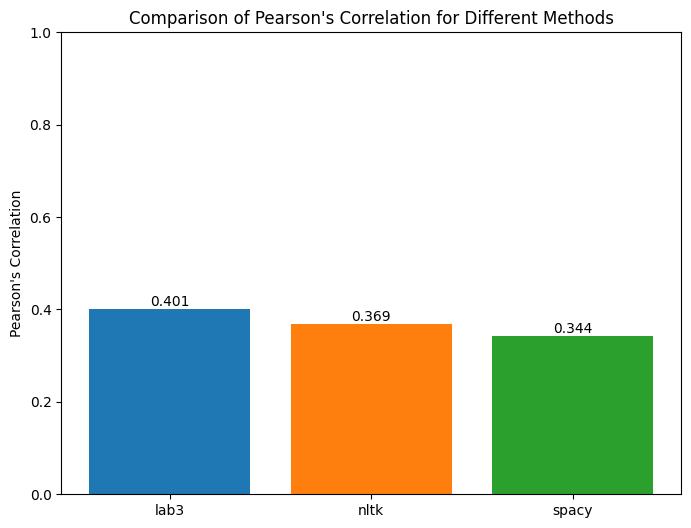

In [ ]:
# comparing a benchmark (lab 3) against the current two methods:
plot_pearson_comparison([pearson_cor_lab3, pearson_cor_nltk, pearson_cor_spacy], ['lab3', 'nltk', 'spacy'])

 Both methods seem to underperform, with nltk doing slightly better than spacy. Let's visualize head-to-head their performance:

In [ ]:
# lists so we can check who made what changes
nltk_changes      = []
spacy_changes     = []
both_changed      = []
only_nltk_changed = []
only_spacy_changed= []

# compare
def detect_changes(row):
    original_tokens = word_tokenize(row['s0'])
    nltk_tokens   = row['s0_nltk']
    spacy_tokens  = row['s0_spacy']

    nltk_changed  = nltk_tokens != original_tokens
    spacy_changed = spacy_tokens != original_tokens

    nltk_changes.append(nltk_changed)
    spacy_changes.append(spacy_changed)

    if nltk_changed and spacy_changed:
        both_changed.append(True)
        only_nltk_changed.append(False)
        only_spacy_changed.append(False)
    elif nltk_changed and not spacy_changed:
        both_changed.append(False)
        only_nltk_changed.append(True)
        only_spacy_changed.append(False)
    elif not nltk_changed and spacy_changed:
        both_changed.append(False)
        only_nltk_changed.append(False)
        only_spacy_changed.append(True)
    else:
        both_changed.append(False)
        only_nltk_changed.append(False)
        only_spacy_changed.append(False)

    return pd.Series({
        'nltk_changed': nltk_changed,
        'spacy_changed': spacy_changed
    })

In [ ]:
dt[['nltk_changed', 'spacy_changed']] = dt.apply(detect_changes, axis=1) # find changes at any row!

In [19]:
# this looks complex but is just counts and prints, one can just look at results

total_sentences           = len(dt)
nltk_changed_count        = sum(dt['nltk_changed'])
spacy_changed_count       = sum(dt['spacy_changed'])
both_changed_count        = sum(dt['nltk_changed'] & dt['spacy_changed'])
only_nltk_changed_count   = sum(dt['nltk_changed'] & ~dt['spacy_changed'])
only_spacy_changed_count  = sum(~dt['nltk_changed'] & dt['spacy_changed'])

print(f"Total sentences: {total_sentences}")
print(f"NLTK made changes in {nltk_changed_count} sentences.")
print(f"spaCy made changes in {spacy_changed_count} sentences.")
print(f"Both NLTK and spaCy made changes in {both_changed_count} sentences.")
print(f"Only NLTK made changes in {only_nltk_changed_count} sentences.")
print(f"Only spaCy made changes in {only_spacy_changed_count} sentences.")

# show some examples where they are different!
differences = dt[(dt['nltk_changed'] != dt['spacy_changed'])]

print("\nExamples where NLTK and spaCy made different changes:")
for idx, row in differences.head(5).iterrows():
    print(f"\nSentence index: {idx}")
    print(f"Original Sentence: {row['s0']}")
    print(f"Original Tokens: {word_tokenize(row['s0'])}")
    print(f"NLTK Tokens: {row['s0_nltk']}")
    print(f"spaCy Tokens: {row['s0_spacy']}")


Total sentences: 317
NLTK made changes in 27 sentences.
spaCy made changes in 45 sentences.
Both NLTK and spaCy made changes in 27 sentences.
Only NLTK made changes in 0 sentences.
Only spaCy made changes in 18 sentences.

Examples where NLTK and spaCy made different changes:

Sentence index: 3
Original Sentence: The vote will take place today at 5.30 p.m.
Original Tokens: ['The', 'vote', 'will', 'take', 'place', 'today', 'at', '5.30', 'p.m', '.']
NLTK Tokens: ['The', 'vote', 'will', 'take', 'place', 'today', 'at', '5.30', 'p.m', '.']
spaCy Tokens: ['The', 'vote', 'will', 'take', 'place', 'today', 'at', '5.30 p.m.']

Sentence index: 5
Original Sentence: Neither was there a qualified majority within this House to revert to Article 272.
Original Tokens: ['Neither', 'was', 'there', 'a', 'qualified', 'majority', 'within', 'this', 'House', 'to', 'revert', 'to', 'Article', '272', '.']
NLTK Tokens: ['Neither', 'was', 'there', 'a', 'qualified', 'majority', 'within', 'this', 'House', 'to', 'rev

**Analysis:**
Spacy gives a lower pearson correlation than nltk because it works much better at NER! e.g. it can correctly join the time, things like "Article 272", ...

See next section for analysis on why NER worsens performance.

### Exercices 4

Do you think it could be relevant to use NEs to compute the similarity between two sentences? Justify the answer.



**Final Analysis and Conclusion:**

Yes, it could be relevant. Let us first analyse why NEs underperformed, and later argue how they could be better employed.

In our examples, our method underperforms against other methods (e.g. lab3) because we are purely uniting words belonging to the same named entity sequence. Given we use jaccard distance for similarity, which compares directly the sets, we ***lose*** information, as we have less tokens; moreover, the tokens we join tend to be key, as named entities are usually important to the meaning of the sentence.


A correct way to use NEs could be to recognise when two sentences are talking of the same kind of thing. Let us illustrate with an example, given two sentences:
  - A: "John Smith bought a house in London."
  - B: "Emily Johnson purchased a home in Paris."

If we focused only on the tokens and jaccard similarity, we would end up with a similarity of 0, even though the sentences are quite similar! If we instead realise they both say someone is buying a house, and add as extra information that the first two tokens constitute a PERSON, and the last token constitues a LOCATION, we could significantly improve our similarity measure. Perhaps we could give less, but still some weight, when tokens do not match directly but they share the same NE.